<a href="https://colab.research.google.com/github/XueYang0130/1CSD1_Thesis/blob/main/4_Qflip_Multi_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**Part 1**
### In this experiment, both players (p0: defender, p1: attacker) employ LM adaptive strategies. We create a new Reward Function which has been described in the thesis. The assumptions of the experiment are the same as in the one-agent QFlip.

In [2]:
#import libraries
import numpy as np
import random 
import matplotlib.pyplot as plt

In [3]:
#define an environment class
#two agents: p0 - defender, p1 - attacker

class Env(object):
  def __init__(self):
    #initialization
    self.actions=[[0,1],[0,0],[1,1],[1,0]] #Four action combinations. In each list, the 1st element is p0's action, the 2nd element of p1's action
    self.tick=0 
    self.cost=[1,5] #the 1st element is p0's cost, the 2nd element of p1's cost
    self.reward_constant_norm=[1,5] 
    self.c=5 #normalization constant 
    self.init_state= [0,0] #initial state observed by players
    self.state = self.init_state # 'state': the time since the opponent's last "know" move at time t (maybe not true last move time)
    self.p0_moves = [0] #a list of move times of p0
    self.p1_moves = [0] #a list of move times of p1
    self.duration=300000 #the maximum time steps
    self.done=False #indicates whether the game is over
    self.controller=0 #before the game starts, p0/defender controls the resource
    self.total_gain=[0,0] #total controling time to p0 and p1
    self.total_cost=[0,0] #total cost to p0 and p1
    self.p0_avr_benefit=[] #p0's average benefit: (hold time- total cost)/time steps
    self.p1_avr_benefit=[] #p1's average benefit: (hold time- total cost)/time steps
    self.avr_hold_time=[0,0]

  def step(self,actions,tick):
    reward = [0,0] #indicate the reward two players gain in thie time step

    #p0/defender and p1/attacker move together, p0/defender controls the resource, p1 doesn't gain any benefit but has a cost.
    if actions == [1,1]:
        #p0/defender consecutive:
        if self.controller==0: #p0 moves when it has already controlled the resource
          #update rewards and states to p0 and p1
          reward = [-self.cost[0],-self.cost[1]]
          self.state[1]+=1
          self.state[0]+=1
        #p0/defender flipping:
        else:
          #update rewards and states to p0 and p1
          reward = [self.reward_constant_norm[0], -self.cost[1]]
          self.state[1]+=1
          self.state[0] = tick - self.p1_moves[-1] +1
        self.controller=0 #after the action, the controller is p0
        self.p0_moves.append(tick) #update the list of p0's move times
        self.total_cost[0]+=self.cost[0] #update total costs to p0 and p1
        self.total_cost[1]+=self.cost[1]

    #p0/defender doesn't move, p1/attacker moves
    elif actions==[0,1]:
        #p1/attacker flipping:
        if self.controller==0: #p1 moves when p0 controls the resource
          #again, update rewards and states to p0 and p1
          reward = [0,self.reward_constant_norm[1]]
          self.state[1]+=tick - self.p0_moves[-1] +1
          self.state[0]+=1
        #p1/attacker consecutive:
        else:
          #update rewards and states to p0 and p1
          reward = [0,-self.cost[1]]
          self.state[1]+=1
          self.state[0]+=1
        self.controller=1 #after the action, the controller is p1
        self.p1_moves.append(tick) #update the list of p1's move times
        self.total_cost[1]+=self.cost[1] #update total cost to p1

    #p0/defender moves, p1/attacker doesn't move
    elif actions==[1,0]:
       #p0/defender consecutive: 
        if self.controller==0: #p0 moves when it has already controlled the resource
          #update rewards and states to p0 and p1
          reward = [-self.cost[0],0] 
          self.state[1]+=1
          self.state[0]+=1
        #p0/defender flipping:
        else:
          #update rewards and states to p0 and p1
          reward = [self.reward_constant_norm[0],0]
          self.state[1]+=1
          self.state[0] = tick - self.p1_moves[-1] +1
        self.controller=0 #after the action, the controller is p0
        self.p0_moves.append(tick) #update the list of p0's move times
        self.total_cost[0]+=self.cost[0] #update total cost to p0
    
    #p0 and p1 both don't move. Their don't receive rewards.
    elif actions==[0,0]: 
        #update states
        self.state[1]+= 1
        self.state[0]+=1

    #check if the game is over
    if tick==self.duration: 
      self.done=True
    
    #update the value of total gain (also the holding time of the resource) to the controller
    self.total_gain[self.controller]+=1

    #calculate average benefit to p0 and p1 so far: (total gain-total cost)/total ticks
    self.p0_avr_benefit.append((self.total_gain[0]-self.total_cost[0])/(tick+1))
    self.p1_avr_benefit.append((self.total_gain[1]-self.total_cost[1])/(tick+1))

    #calcuate average holding time to p0 and p1: total gain/ total number of moves
    self.avr_hold_time[0]=self.total_gain[0]/len(self.p0_moves)
    self.avr_hold_time[1]=self.total_gain[1]/len(self.p1_moves)

    #calculate the rewards that will be used in the next time step to p0 and p1, respectively.
    #(average holding time- cost per move)/normalization constant
    self.reward_constant_norm[0]=(self.avr_hold_time[0]-self.cost[0])/self.c
    self.reward_constant_norm[1]=(self.avr_hold_time[1]-self.cost[1])/self.c

    return self.state, reward, self.done #return next state/observation, reward for the agent, and state of 'done'
    

  def output(self): #print out moves times of p0 and p1 respectively
    print("p0:",self.p0_moves)
    print("p1:",self.p1_moves)
    

In [4]:
#define an agent class
class Agent(object):
  def __init__(self,env):
    self.env=env
    #initialisation
    self.alpha = 0.3
    self.gamma=0.8
    self.actions=[0,1] 
    self.Q_table=np.zeros((1000000,2)) 
    self.cur_state=self.env.state #get the current state from the environment
    self.next_state=0

  #select an action
  def take_action(self,epsilon):
    action=self.epsilon_greedy(self.cur_state, epsilon)
    return action
  
  #update Q table and state
  def new_do_step(self,state,reward,action,done):
    self.update_Q(reward, self.cur_state, state,action)
    self.cur_state=state
    return done

  #for exporation-exploitation
  def epsilon_greedy(self, state, epsilon): 
    if np.random.rand()<epsilon:
      return random.choice(self.actions) 
    else:
      return np.argmax(self.Q_table[state])

  #method for updating Q-table
  def update_Q(self, reward, cur_state, next_state, action): 
    self.Q_table[cur_state, action]=self.Q_table[cur_state, action]+self.alpha*(reward+self.gamma*np.max(self.Q_table[next_state])-self.Q_table[cur_state,action])



In [5]:
env = Env() #create an environment object
defender=Agent(env) #create an agent object to be the defender
attacker=Agent(env) #create an agent object to be the attacker
epsilon = 0.5 #initial value of epsilon
for tick in range(env.duration):
  epsilon=max(epsilon-1/290000,0.01) # decay epsilon
  defender_action = defender.take_action(epsilon) #defender selects an action
  attacker_action = attacker.take_action(epsilon) #attacker selects an action
  actions = [defender_action, attacker_action] #action combination
  #get next states, rewards and state of done from the environment according to action combination
  next_states, rewards, done=env.step(actions,tick) 
  #update the environment including the Q table
  defender.new_do_step(next_states[0],rewards[0],actions[0],done) 
  attacker.new_do_step(next_states[1],rewards[1],actions[1],done) 

###**Part 2**

###Print the average holding time for p0 and p1, respectively. This indicates how much additional controling time of the resouce the player can gain for each move. The more time gained, the better of the result.

In [6]:
print("Average holding time for p0:", env.avr_hold_time[0])
print("Average holding time for p1:", env.avr_hold_time[1])

Average holding time for p0: 8.495386176986251
Average holding time for p1: 7.337787347223101


###Print the average benefits over time for p0 and p1, respectively. The equation is as follows: (total gain-total cost)/t, where t=1, 2, 3, .... Due to the print limit, only the last 100 values are printed. We can notice that the values have converged.

In [7]:
print("Average benefits over time for p0:", env.p0_avr_benefit[-100:])
print("Average benefits over time for p1:", env.p1_avr_benefit[-100:])

Average benefits over time for p0: [0.5414620157985468, 0.5414602103353762, 0.5414584048842459, 0.5414565994451558, 0.5414547940181057, 0.5414529886030957, 0.5414511832001254, 0.5414493778091948, 0.5414475724303038, 0.5414457670634524, 0.5414439617086402, 0.5414421563658673, 0.5414403510351335, 0.5414385457164387, 0.5414367404097827, 0.5414349351151656, 0.5414331298325871, 0.541431324562047, 0.5414295193035453, 0.5414277140570819, 0.5414259088226566, 0.5414241036002694, 0.5414222983899201, 0.5414204931916086, 0.5414186880053347, 0.5414168828310983, 0.5414150776688994, 0.5414132725187378, 0.5414114673806134, 0.5414129963658187, 0.5414145253408283, 0.5414160543056427, 0.5414175832602615, 0.5414191122046851, 0.5414206411389134, 0.5414221700629468, 0.5414236989767851, 0.5414252278804286, 0.5414267567738773, 0.5414282856571314, 0.5414298145301909, 0.541431343393056, 0.5414328722457267, 0.5414344010882032, 0.5414359299204854, 0.5414374587425737, 0.541438987554468, 0.5414405163561684, 0.54144

###Visualization the Average Benefit Curves. The result shows that the average benefits for two players converg.

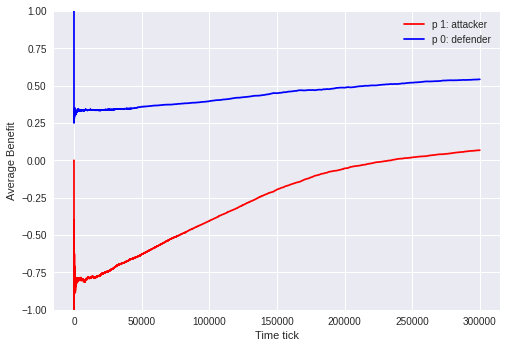

In [8]:
#visualiztaion
plt.style.use('seaborn')
plt.figure()
plt.plot(np.array(range(len(env.p1_avr_benefit))), env.p1_avr_benefit,color = "red",label="p 1: attacker")
plt.plot(np.array(range(len(env.p1_avr_benefit))), env.p0_avr_benefit, color = "blue",label="p 0: defender")
plt.ylim(-1, 1)
plt.xlabel("Time tick")
plt.ylabel("Average Benefit")
plt.legend()

###Next, observe the duration between two adjacent moves for each player.

In [11]:
p0_interval_ls = []
p1_interval_ls = []
i=0
j=0
while i < len(env.p0_moves)-1:
  p0_interval_ls.append(env.p0_moves[i+1]-env.p0_moves[i])
  i+=1
while j < len(env.p1_moves)-1:
  p1_interval_ls.append(env.p1_moves[j+1]-env.p1_moves[j])
  j+=1


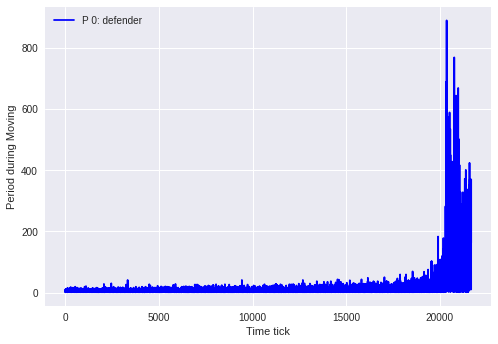

In [17]:
plt.style.use('seaborn')
plt.figure()
plt.plot(range(len(p0_interval_ls)),p0_interval_ls,color = "blue",label="P 0: defender")
plt.xlabel("Time tick")
plt.ylabel("Period during Moving (ticks)")
plt.legend()

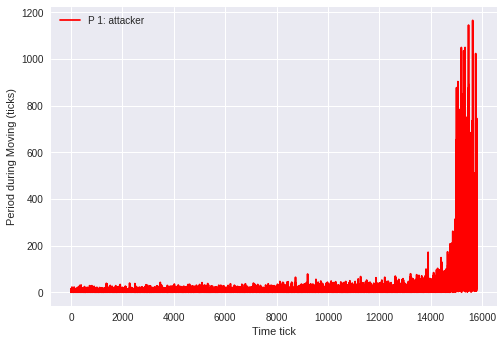

In [18]:
plt.style.use('seaborn')
plt.figure()
plt.plot(range(len(p1_interval_ls)),p1_interval_ls,color = "red",label="P 1: attacker")
plt.xlabel("Time tick")
plt.ylabel("Period during Moving (ticks)")
plt.legend()